<a href="https://colab.research.google.com/github/gracelcai/career-launch-group-13/blob/main/ExerciseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Pose Coordinates with MediaPipe

## Setup

Make sure you upload your video file into files

In [ ]:
# Installing MediaPipe
!pip install -q mediapipe==0.10.0
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

## Get Frames

In [ ]:
# upload video file
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving squat_18.mp4 to squat_18 (2).mp4


In [ ]:
import cv2
# getting video
video = cv2.VideoCapture(filename)

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# displaying video
print("Your video:\n")
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Your video:



In [ ]:
# displaying frames per second
fps = video.get(cv2.CAP_PROP_FPS)
print('frame per seconds = ', fps)

frame per seconds =  25.0


your starting frame:



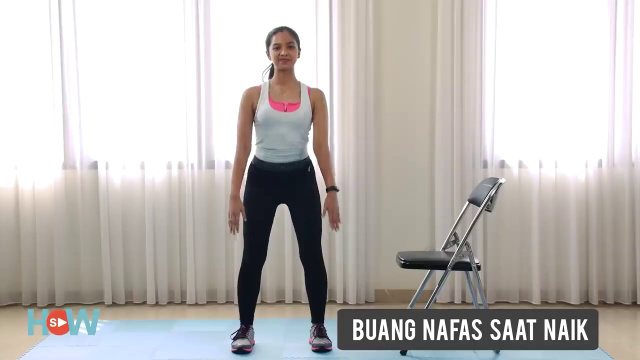



your ending frame:



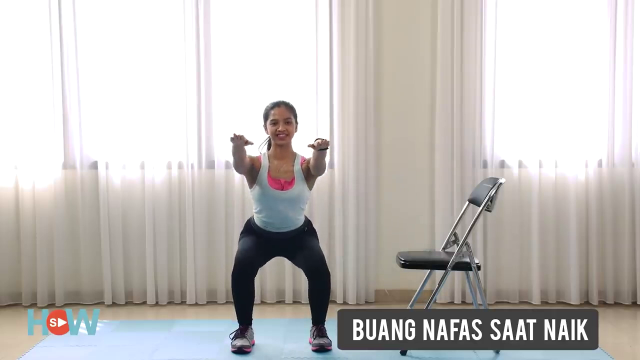

In [ ]:
#@markdown enter the frame of your starting pose you would like to choose based on the time stamp in the video
from google.colab.patches import cv2_imshow
start_minutes = 0 # @param {type: "integer"}
start_seconds = 0 # @param {type: "integer"}

# getting frame from time stamp of video
start_t_msec = 1000 * (start_minutes * 60 + start_seconds)
video.set(cv2.CAP_PROP_POS_MSEC, start_t_msec)
start_ret, start_frame = video.read()

start_frame = cv2.resize(start_frame, (0, 0), fx = 0.5, fy = 0.5)

# displaying starting frames
print("your starting frame:\n")
cv2_imshow(start_frame)

#@markdown enter the frame of your ending pose that you would like to choose based on the time stamp in the video
from google.colab.patches import cv2_imshow
end_minutes = 0 # @param {type: "integer"}
end_seconds = 1 # @param {type: "integer"}

# getting frame from time stamp of video
end_t_msec = 1000 * (end_minutes * 60 + end_seconds)
video.set(cv2.CAP_PROP_POS_MSEC, end_t_msec)
end_ret, end_frame = video.read()
end_frame = cv2.resize(end_frame, (0, 0), fx = 0.5, fy = 0.5)

# displaying ending frame
print("\n\nyour ending frame:\n")
cv2_imshow(end_frame)

In [ ]:
cv2.imwrite('start_frame.jpg', start_frame)
cv2.imwrite('end_frame.jpg', end_frame)

True

## Detecting Starting Pose

starting frame:



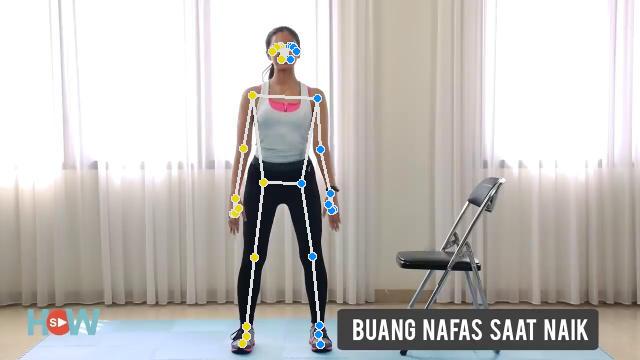

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as start_mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = start_mp.Image.create_from_file("start_frame.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
print("starting frame:\n")
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

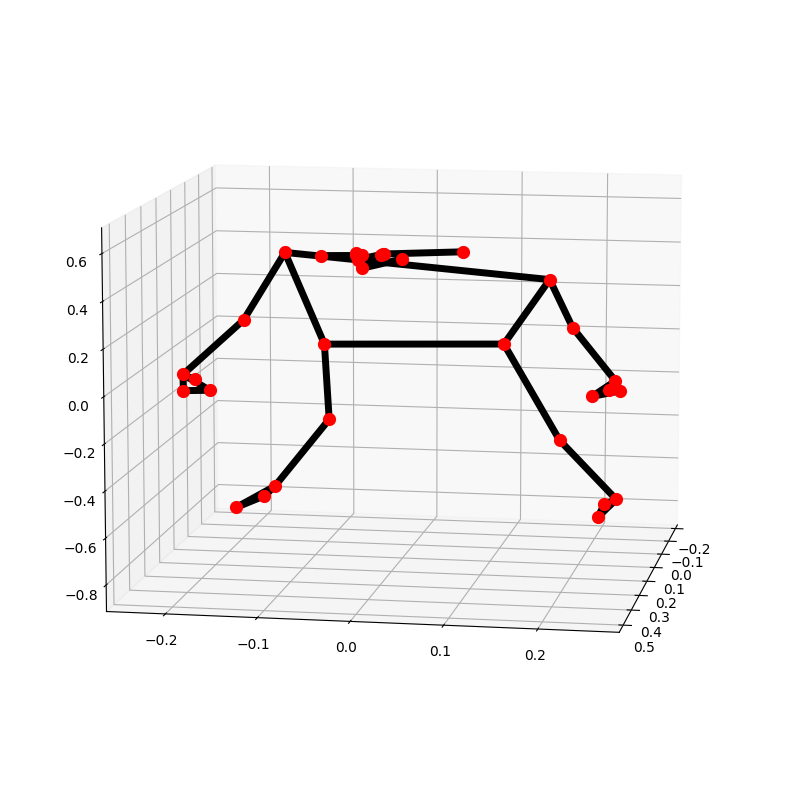

In [ ]:
# For static images:
start_mp_drawing = start_mp.solutions.drawing_utils
start_mp_drawing_styles = start_mp.solutions.drawing_styles
start_mp_pose = start_mp.solutions.pose
BG_COLOR = (192, 192, 192) # gray
with start_mp_pose.Pose(
    static_image_mode = True,
    model_complexity = 2,
    enable_segmentation = True,
    min_detection_confidence = 0.5) as pose:

  image = cv2.imread("start_frame.jpg")
  image_height, image_width, _ = image.shape
  # Convert the BGR image to RGB before processing.
  start_results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  #print(
  #    f'Nose coordinates: ('
  #    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
  #    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
  #)

  annotated_image = image.copy()
  # Draw segmentation on the image.
  # To improve segmentation around boundaries, consider applying a joint
  # bilateral filter to "results.segmentation_mask" with "image".
  condition = np.stack((start_results.segmentation_mask,) * 3, axis=-1) > 0.1
  bg_image = np.zeros(image.shape, dtype=np.uint8)
  bg_image[:] = BG_COLOR
  annotated_image = np.where(condition, annotated_image, bg_image)

  # Draw pose landmarks on the image.
  start_mp_drawing.draw_landmarks(
      annotated_image,
      start_results.pose_landmarks,
      start_mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec = start_mp_drawing_styles.get_default_pose_landmarks_style())
  cv2.imwrite('/tmp/annotated_image.jpg', annotated_image)

  # Plot pose world landmarks.
  start_mp_drawing.plot_landmarks(
      start_results.pose_world_landmarks, start_mp_pose.POSE_CONNECTIONS)

## Detecting Ending Pose

ending frame:



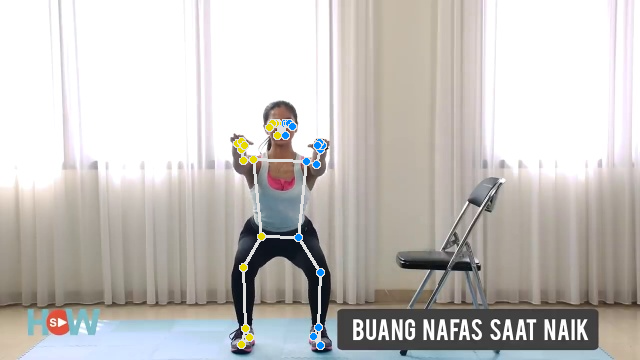

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as end_mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = end_mp.Image.create_from_file("end_frame.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
print("ending frame:\n")
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


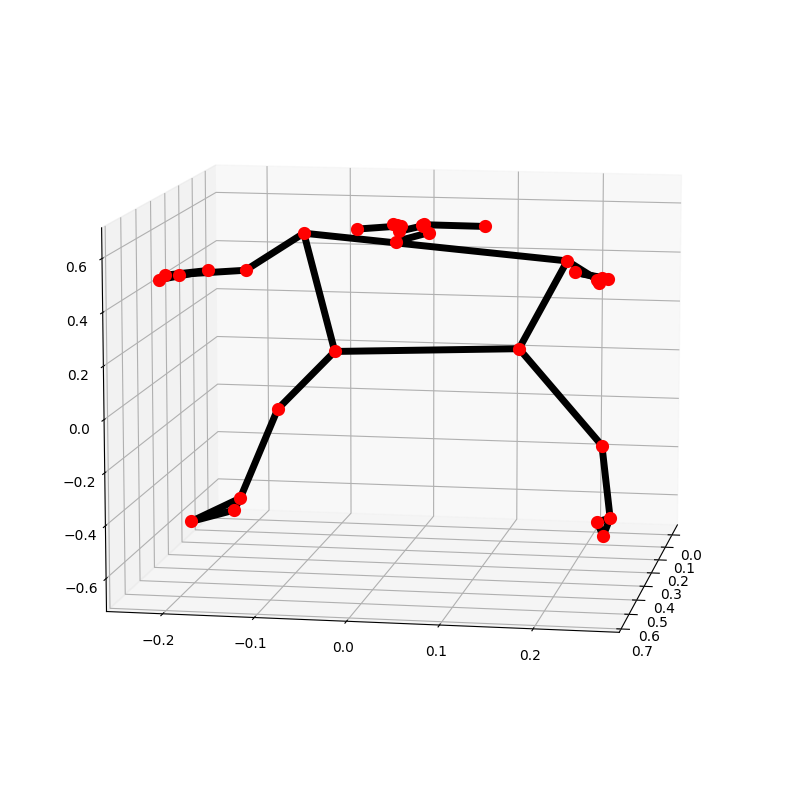

In [ ]:
# For static images:
end_mp_drawing = end_mp.solutions.drawing_utils
end_mp_drawing_styles = end_mp.solutions.drawing_styles
end_mp_pose = end_mp.solutions.pose
BG_COLOR = (192, 192, 192) # gray
with end_mp_pose.Pose(
    static_image_mode = True,
    model_complexity = 2,
    enable_segmentation = True,
    min_detection_confidence = 0.5) as pose:

  image = cv2.imread("end_frame.jpg")
  image_height, image_width, _ = image.shape
  # Convert the BGR image to RGB before processing.
  end_results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  #print(
  #    f'Nose coordinates: ('
  #    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
  #    f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
  #)

  annotated_image = image.copy()
  # Draw segmentation on the image.
  # To improve segmentation around boundaries, consider applying a joint
  # bilateral filter to "results.segmentation_mask" with "image".
  condition = np.stack((end_results.segmentation_mask,) * 3, axis=-1) > 0.1
  bg_image = np.zeros(image.shape, dtype=np.uint8)
  bg_image[:] = BG_COLOR
  annotated_image = np.where(condition, annotated_image, bg_image)

  # Draw pose landmarks on the image.
  end_mp_drawing.draw_landmarks(
      annotated_image,
      end_results.pose_landmarks,
      end_mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec = end_mp_drawing_styles.get_default_pose_landmarks_style())
  cv2.imwrite('/tmp/annotated_image_end.jpg', annotated_image)

  # Plot pose world landmarks.
  end_mp_drawing.plot_landmarks(
      end_results.pose_world_landmarks, end_mp_pose.POSE_CONNECTIONS)

# print("\n\nending frame:\n")
# end_results = show_pose_landmarks("end_frame.jpg")

## Finding Coordinates

In [ ]:
start_frame_hight, start_frame_width, _ = start_frame.shape
end_frame_hight, end_frame_width, _ = end_frame.shape
# Note: the times 100 might be wrong idk

# Getting XYZ-coordinates of nose
x1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].x * image_width
x2_coordinate = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].x * image_width
y1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].y * image_height
y2_coordinate = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].y * image_height
z1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].z * 100
z2_coordinate = start_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].z * 100
print("Initial Coordinates of Nose:")
print("x:", x1_coordinate)
print("y:", y1_coordinate)
print("z:", z1_coordinate)

print("\nFinal Coordinates of Nose:")
print("x:", x2_coordinate)
print("y:", y2_coordinate)
print("z:", z2_coordinate)
image_width, image_height

Initial Coordinates of Nose:
x: 284.91443634033203
y: 52.418625354766846
z: -45.57003974914551

Final Coordinates of Nose:
x: 281.46839141845703
y: 129.35921788215637
z: -45.57003974914551


(640, 360)

In [ ]:
import math
# Finding distance in specified axis (for different parts)
def xyz_distances(start_position, end_position, axis):
  if(axis == 'x'):
    return end_position.x - start_position.x
  elif(axis == 'y'):
    return end_position.y - start_position.y
  else:
    return end_position.z - start_position.z

# Finding distance in specified axis (for same part)
def landmarks(start_position, end_position, axis):
  if(axis == 'x'):
    return end_position.x - start_position.x
  elif(axis == 'y'):
    return end_position.y - start_position.y
  else:
    return end_position.z - start_position.z

# Finding 3D distances
def distance_3D(start_position, end_position):
  x = end_position.x - start_position.x
  y = end_position.y - start_position.y
  z = end_position.z - start_position.z
  return math.sqrt(x**2 + y**2 + z**2)

def angle(start_position, end_position):
  a = start_position.x * end_position.x + start_position.y * end_position.y + start_position.z * end_position.z
  a /= math.sqrt((start_position.x**2 + start_position.y**2 + start_position.z**2) * (end_position.x**2 + end_position.y**2 + end_position.z**2))
  a = math.acos(a) * 180 / math.pi
  return a

In [ ]:
x1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].x
x2_coordinate = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].x
print("x distance:", xyz_distances(x1_coordinate, x2_coordinate))

y1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].y
y2_coordinate = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].y
print("y distance:", xyz_distances(y1_coordinate, y2_coordinate))

z1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].z
z2_coordinate = start_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].z
print("z distance:", xyz_distances(z1_coordinate, z2_coordinate))

start_pos = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE]
end_pos = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE]

print("x distance:", xyz_distances(x1_coordinate, x2_coordinate))

print("\n3D distance:", distance_3D(start_pos, end_pos))

print("\nAngle:", angle(start_pos, end_pos), "degrees")

TypeError: xyz_distances() missing 1 required positional argument: 'axis'

# Turn data into tensors

In [ ]:
import torch
import numpy as np

# list of corresponding landmark indices for distance calculation
pose_landmark = start_mp_pose.PoseLandmark
distances_dict = [
    (pose_landmark.LEFT_SHOULDER, pose_landmark.LEFT_WRIST),
    (pose_landmark.RIGHT_SHOULDER, pose_landmark.RIGHT_WRIST),
    (pose_landmark.LEFT_HIP, pose_landmark.LEFT_ANKLE),
    (pose_landmark.RIGHT_HIP, pose_landmark.RIGHT_ANKLE),
    (pose_landmark.LEFT_HIP, pose_landmark.LEFT_WRIST),
    (pose_landmark.RIGHT_HIP, pose_landmark.RIGHT_WRIST),
    (pose_landmark.LEFT_SHOULDER, pose_landmark.LEFT_ANKLE),
    (pose_landmark.RIGHT_SHOULDER, pose_landmark.RIGHT_ANKLE),
    (pose_landmark.LEFT_HIP, pose_landmark.RIGHT_WRIST),
    (pose_landmark.RIGHT_HIP, pose_landmark.LEFT_WRIST),
    (pose_landmark.LEFT_ELBOW, pose_landmark.RIGHT_ELBOW),
    (pose_landmark.LEFT_KNEE, pose_landmark.RIGHT_KNEE),
    (pose_landmark.LEFT_WRIST, pose_landmark.RIGHT_WRIST),
    (pose_landmark.LEFT_ANKLE, pose_landmark.RIGHT_ANKLE)
]

angles_dict = []
def get_landmark_tensor(landmarks):
  landmarks_tensor = torch.empty((0), dtype=torch.float)
  # print("initial tensor", landmarks_tensor)

  for landmark in landmarks:
    landmarks_tensor = torch.cat([landmarks_tensor, torch.tensor([landmark.x, landmark.y, landmark.z])], dim=0)
  return landmarks_tensor

def get_distances_tensor(landmarks):
  distances_tensor = torch.empty((0), dtype=torch.float)
  for (start, end) in distances_dict:
    # print(f"start: {start}, end: {end}")
    distances_tensor = torch.cat([distances_tensor, torch.tensor(distance_3D(landmarks[start], landmarks[end])).unsqueeze(0)], dim=0)
  return distances_tensor

def get_xyz_distances_tensor(landmarks):
  xyz_distances_tensor = torch.empty((0), dtype=torch.float)
  for (start, end) in distances_dict:
    # print(f"start: {start}, end: {end}")
    xyz_distances_tensor = torch.cat([xyz_distances_tensor,
                                      torch.tensor([xyz_distances(landmarks[start], landmarks[end], 'x'),
                                                   xyz_distances(landmarks[start], landmarks[end], 'y'),
                                                   xyz_distances(landmarks[start], landmarks[end], 'z')])], dim=0)
  return xyz_distances_tensor

def get_angles_tensor(landmarks):
  angles_tensor = torch.empty((0), dtype=torch.float)
  # TODO: add angles into tensor
  return angles_tensor

In [ ]:
# start tensors
start_landmarks_tensor = get_landmark_tensor(start_results.pose_landmarks.landmark)
start_distances_tensor = get_distances_tensor(start_results.pose_landmarks.landmark)
start_xyz_distances_tensor = get_xyz_distances_tensor(start_results.pose_landmarks.landmark)
start_angles_tensor = get_angles_tensor(start_results.pose_landmarks.landmark)
print(f"start landmarks tensor: {start_landmarks_tensor}")
print(f"start distances tensor: {start_distances_tensor}")
print(f"start xyz distances tensor: {start_xyz_distances_tensor}")
print(f"start angles tensor: {start_angles_tensor}")

start landmarks tensor: tensor([ 0.4452,  0.1456, -0.4557,  0.4518,  0.1298, -0.4380,  0.4552,  0.1306,
        -0.4384,  0.4589,  0.1318, -0.4383,  0.4388,  0.1300, -0.4391,  0.4349,
         0.1311, -0.4395,  0.4315,  0.1323, -0.4396,  0.4632,  0.1432, -0.3162,
         0.4256,  0.1441, -0.3196,  0.4534,  0.1657, -0.4067,  0.4394,  0.1651,
        -0.4096,  0.4961,  0.2726, -0.2088,  0.3943,  0.2656, -0.2227,  0.5015,
         0.4144, -0.1680,  0.3792,  0.4117, -0.2021,  0.5164,  0.5381, -0.2765,
         0.3677,  0.5500, -0.3057,  0.5208,  0.5830, -0.3093,  0.3644,  0.5928,
        -0.3469,  0.5182,  0.5853, -0.3532,  0.3676,  0.5940, -0.3820,  0.5132,
         0.5691, -0.2954,  0.3723,  0.5787, -0.3235,  0.4710,  0.5102,  0.0101,
         0.4111,  0.5076, -0.0104,  0.4884,  0.7115,  0.0222,  0.3971,  0.7154,
        -0.0082,  0.4992,  0.9047,  0.1687,  0.3846,  0.9069,  0.1146,  0.4977,
         0.9305,  0.1732,  0.3850,  0.9368,  0.1190,  0.5023,  0.9585,  0.0189,
         0.3790,

In [ ]:
# end tensors
end_landmarks_tensor = get_landmark_tensor(end_results.pose_landmarks.landmark)
end_distances_tensor = get_distances_tensor(end_results.pose_landmarks.landmark)
end_xyz_distances_tensor = get_xyz_distances_tensor(end_results.pose_landmarks.landmark)
end_angles_tensor = get_angles_tensor(end_results.pose_landmarks.landmark)
print(f"end landmarks tensor: {end_landmarks_tensor}")
print(f"end distances tensor: {end_distances_tensor}")
print(f"end xyz distances tensor: {end_xyz_distances_tensor}")
print(f"end angles tensor: {end_angles_tensor}")

end landmarks tensor: tensor([ 0.4398,  0.3593, -0.2293,  0.4455,  0.3426, -0.2125,  0.4492,  0.3431,
        -0.2127,  0.4532,  0.3437, -0.2127,  0.4336,  0.3424, -0.2123,  0.4302,
         0.3426, -0.2126,  0.4262,  0.3431, -0.2126,  0.4578,  0.3505, -0.1200,
         0.4211,  0.3529, -0.1195,  0.4463,  0.3756, -0.1941,  0.4337,  0.3760,
        -0.1953,  0.4786,  0.4485, -0.1283,  0.3969,  0.4452, -0.1244,  0.4946,
         0.4599, -0.3942,  0.3804,  0.4482, -0.4123,  0.5006,  0.4139, -0.6501,
         0.3776,  0.4157, -0.6922,  0.5043,  0.4024, -0.7034,  0.3726,  0.3990,
        -0.7509,  0.4994,  0.3967, -0.7005,  0.3783,  0.3943, -0.7413,  0.4958,
         0.4043, -0.6571,  0.3820,  0.4054, -0.6988,  0.4667,  0.6610,  0.0067,
         0.4079,  0.6575, -0.0070,  0.5005,  0.7569, -0.3272,  0.3804,  0.7423,
        -0.3339,  0.4974,  0.9109, -0.2164,  0.3841,  0.9120, -0.2852,  0.4905,
         0.9351, -0.2142,  0.3895,  0.9374, -0.2880,  0.5021,  0.9597, -0.3458,
         0.3777,  

In [ ]:
# order of tensors: distances, xyz_distances, angles, landmarks
start_tensor = torch.cat([start_distances_tensor, start_xyz_distances_tensor, start_angles_tensor, start_landmarks_tensor])
end_tensor = torch.cat([end_distances_tensor, end_xyz_distances_tensor, end_angles_tensor, end_landmarks_tensor])
print(f"full start tensor: {start_tensor}")
print(f"full end tensor: {end_tensor}")

full start tensor: tensor([ 0.2747,  0.2974,  0.4261,  0.4193,  0.2916,  0.3015,  0.7363,  0.7247,
         0.3347,  0.2878,  0.1270,  0.0964,  0.1520,  0.1268,  0.0203,  0.2655,
        -0.0677, -0.0266,  0.2844, -0.0830,  0.0282,  0.3945,  0.1586, -0.0265,
         0.3994,  0.1250,  0.0454,  0.0279, -0.2866, -0.0434,  0.0424, -0.2953,
         0.0031,  0.6321,  0.3775, -0.0097,  0.6413,  0.3373, -0.1033,  0.0398,
        -0.3159,  0.1053,  0.0305, -0.2661, -0.1224, -0.0027, -0.0341, -0.0913,
         0.0039, -0.0304, -0.1487,  0.0119, -0.0292, -0.1146,  0.0022, -0.0541,
         0.4452,  0.1456, -0.4557,  0.4518,  0.1298, -0.4380,  0.4552,  0.1306,
        -0.4384,  0.4589,  0.1318, -0.4383,  0.4388,  0.1300, -0.4391,  0.4349,
         0.1311, -0.4395,  0.4315,  0.1323, -0.4396,  0.4632,  0.1432, -0.3162,
         0.4256,  0.1441, -0.3196,  0.4534,  0.1657, -0.4067,  0.4394,  0.1651,
        -0.4096,  0.4961,  0.2726, -0.2088,  0.3943,  0.2656, -0.2227,  0.5015,
         0.4144, -0.1

# Make prediction using start and end tensors

In [ ]:
# TODO import model

# Old Stuff

## Setup:

In [ ]:
# import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

## Preparing data:

In [ ]:
# Setup training data
train_data = # TODO

test_data = # TODO

In [ ]:
# Turn train dataset into DataLoader
from torch.utils.data import DataLoader

# setup batch size hyperparameter
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                           batch_size = BATCH_SIZE,
                           shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

train_dataloader, test_dataloader

## Creating the Model:

In [ ]:
from torch import nn
class Exercise_Model(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        # TODO
    )

  def forward(self, x):
    return # TODO

In [ ]:
# setup model

model = Exercise_Model(
    input_shape = ,
    hidden_units = ,
    output_shape =
).to(device)

model

In [ ]:
##### POSSIBLY WRONG
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measures how wrong model is TODO: are we using CrossEntropyLoss?
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1) # TODO: Do we want to use SGD?

## Training and Testing Functions

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """ Performs a training with model trying to learn on data_loader"""
  train_loss, train_acc = 0, 0

  model.train()

  # Add loop to loop through training batches
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(y_true = y,
                             y_pred = y_pred.argmax(dim = 1)) # from logits -> prediction labels

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #TODO: change this up (below)
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs testing loop step on model going over data_loader"""
  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))


    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [ ]:
# If we want to time our model?
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  """
  Prints difference between start and end time
  """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

## Training and Testing the Model:

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set seed and start timer
torch.manual_seed(42)
train_start = timer()

# set number of epochs (small for faster training time)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")

  # Training
  train_loss = 0

  # Add loop to loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model.train()

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:

      test_pred = model(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim = 1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)

  # print whats happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_end = timer()
train_time = print_train_time(start = train_start,
                              end = train_end,
                              device = str(next(model.parameters()).device))

## Evaluating Model:

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """ Returns dictionary containing results of model predicting on data_loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):

      # Make predictions
      y_pred = model(X)

      # Accumulate loss and acc values per batch
      loss += loss_fn(y_pred, y)

      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
    # scale loss and acc to find average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  # TODO: idk if __class__.__name__ is gonna be a thing or not
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}
# Calculate model 0 results on dataset
model_results = eval_model(model = model,
                           data_loader = test_dataloader,
                           loss_fn = loss_fn,
                           accuracy_fn = accuracy_fn,
                           device = device)
model_results

## Import Model

In [ ]:
# TODO: import model

## Use Model to Calculate Accuracy of Exercise

In [ ]:
# TODO: prepare data to be inputted into the model

In [ ]:
# TODO: input data into model and output result